## Process
### Start Bullet Server with ControlHubPlugin
#### windows
```cmd
rnb-control\BulletSimControl\x64\Release\BulletSimControl.exe
```
#### linux
```bash
rnb-control/BulletSimControl/bin/BulletSimControl
```

In [3]:
from bullet_sim_client import *
from utils.trajectory_client.trajectory_client import TrajectoryClient
from utils.web_client import WebClient

## Connect and set physics

In [4]:
init_bullet_sim()

### Load model

In [5]:
ROBOT_TYPE = RobotType.KUKA_IIWA
pc = BulletControlHubClient(get_urdf_path(ROBOT_TYPE), xyz=(0,0,0))

## implement control in python

### initialize state

In [6]:
if ROBOT_TYPE==RobotType.INDY7:
    Q0 = [0, 0, -np.pi / 2, 0, -np.pi / 2, 0] # for indy
else:
    Q0 = [0, -np.pi / 8, 0, np.pi / 4,  0, -np.pi / 8, 0] # for iiwa

pc.initialize_state(Q=Q0)

### test loop

In [7]:
## Calculate s-curve trajectory
N_div = int(2/pc.DT)
Q0 = np.array(Q0)
traj = Q0[np.newaxis, :] + (
    np.arange(N_div+1).astype(float)/N_div*np.pi/4)[:, np.newaxis]
traj = np.array(list(traj) + list(reversed(traj)))

In [8]:
## Reset variables
gamma = 0.5
K   = np.array([  10,  10,  10,   5,   5,   5,   5], dtype=float)[-pc.joint_num:]
Ki  = np.array([   1,   1,   1, 0.5, 0.5, 0.5, 0.5], dtype=float)[-pc.joint_num:]
Kp  = np.array([  10,  10,   5,   5,   3,   2,   2], dtype=float)[-pc.joint_num:]
k_p = np.array([  20,  50,  10,  10,  10,  15,  10], dtype=float)[-pc.joint_num:]
k_v = np.array([   4,  10,   1,   2,   1,   1,   1], dtype=float)[-pc.joint_num:]
tau_max = 300
f_c = 100

eI_nr = np.zeros(pc.joint_num)
lpf_q = LowPassFilter(pc.DT, f_c, Q0)
lpf_qdot = LowPassFilter(pc.DT, f_c, np.zeros(pc.joint_num))
lpf_qddot = LowPassFilter(pc.DT, f_c, np.zeros(pc.joint_num))

In [9]:
dyn_values = []
traj_lp = []
timer = StrictTimer(pc.DT)
for q_d in traj:
    timer.sleep()
    q, qdot, qddot,q_n, qdot_n, p, p_n, M, C, M_n, C_n, \
        tauGrav, tauExt, J, Jdot, J_n, Jdot_n, FText, _, _ = pc.update_state()
    traj_lp.append(lpf_q.update(q))
    qdot = lpf_qdot.update(qdot)
    qddot = lpf_qddot.update(qddot)
    
    # errors
    e_nr = q_n-q
    edot_nr = qdot_n-qdot
    eI_nr += e_nr*pc.DT
    
    # PD control (outer-loop)
    tauPD = k_p*(q_d-q_n) + k_v*(-qdot_n)
    
    # nominal model acceleration
    qddot_n = np.matmul(np.linalg.inv(M_n),
                        (- np.matmul(C_n, qdot_n) + tauPD))
    
    # calculating auxiliary torque, apply cwiseSqrt to reduce deviation between links
    tauAux = (K+1/(gamma*gamma))*(edot_nr + Kp*e_nr + Ki*eI_nr)
    
    # control torque
    torque_out = np.clip(tauGrav + tauPD + tauAux, -tau_max, tau_max)
#     torque_out, qddot_n = tauGrav, qddot # Gravity compenstation

    pc.apply_torque(torque_out, qddot_n)
    pb.stepSimulation()
    dyn_values.append(deepcopy([q, qdot, qddot,q_n, qdot_n, p, p_n, M, C, M_n, C_n, \
        tauGrav, tauExt, J, Jdot, J_n, Jdot_n, FText, torque_out, qddot_n]))

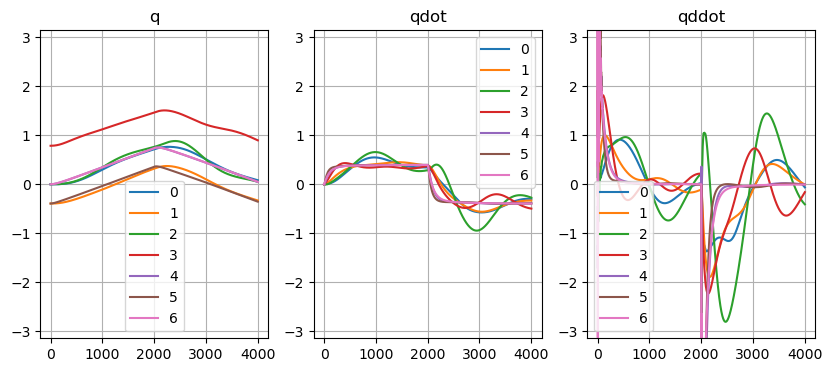

In [10]:
plt.figure(figsize=(10,4))
for i_p in range(3):
    plt.subplot(1,3,i_p+1)
    plot_values(pc, dyn_values, i_p)
    plt.ylim(-np.pi, np.pi)
    plt.grid()

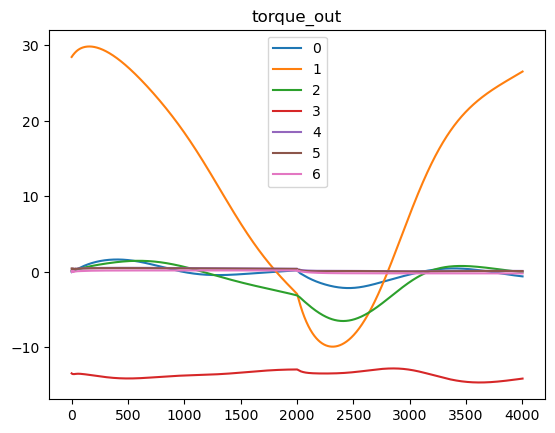

In [11]:
plot_values(pc, dyn_values, -2)

## Test Controller in ControlHub

### initialize control hub

In [19]:
pc.set_control_hub() ## Init ControlHub

### Initialize state

In [20]:
if ROBOT_TYPE==RobotType.INDY7:
    Q0 = [0, 0, -np.pi / 2, 0, -np.pi / 2, 0] # for indy
else:
    Q0 = [0, -np.pi / 8, 0, np.pi / 4,  0, -np.pi / 8, 0] # for iiwa
Q2 = np.add(Q0, np.pi/4)

pc.initialize_state(Q=Q0)

### Test steps in loop

In [21]:
timer = StrictTimer(pc.DT)
for _ in range(5000):
    timer.sleep()
#     pb.applyExternalForce(pc.robot_id, # applying external force
#                           pc.joint_num-1, 
#                           [0,0,0], # force
#                           [0,0,0], # local position
#                           pb.LINK_FRAME)
    pb.stepSimulation()

### Realtime SImulation
* **[NOTE]** pb.setRealTimeSimulation shows very unstable behavior. Below is a alternative that calls pb.stepSimulation() periodically.

In [22]:
start_simulation_thread() # ON

In [23]:
stop_simulation_thread() # OFF

## Test TrajectoryClient

In [24]:
traj_client = TrajectoryClient("localhost")

In [25]:
start_simulation_thread() # ON

In [26]:
traj_client.start_tracking()

{'follow': True}

In [27]:
traj_client.move_joint_s_curve(Q0, N_div=20, 
                               start_tracking=False, auto_stop=False, 
                               wait_finish=False)
traj_client.move_joint_s_curve(Q2, q0=Q0, N_div=50, 
                               start_tracking=False, auto_stop=False, 
                               wait_finish=False)
traj_client.move_joint_s_curve(Q0, q0=Q2, N_div=50, 
                               start_tracking=False, auto_stop=False, 
                               wait_finish=False)

In [28]:
traj_client.stop_tracking()

{'stop': True}

In [29]:
stop_simulation_thread() # OFF

## Adding collision environment

#### add cylinder

In [30]:
radius, height = 0.2, 1.0
center, quat = (0, -0.5, height/2), (0,0,0,1)
add_simple_geom(pb.GEOM_CYLINDER, radius=radius, height=height, 
                center=center, quat=quat)

2

In [31]:
radius, height = 0.2, 1.0
center, quat = (0, -0.5, height/2), (0,0,0,1)
add_simple_geom(pb.GEOM_BOX, halfExtents=[5,5,0.1], 
                center=(0,0,-0.1), quat=quat, 
                rgbaColor=[0.9,0.9,0.9,1])

3

In [32]:
add_simple_geom(pb.GEOM_BOX, halfExtents=[0.1,0.1,0.1], 
                center=(0.5,0,0.3), quat=quat, mass=1, 
                rgbaColor=(0.0,0.9,0.0,1))

4

#### test interaction

In [33]:
start_simulation_thread() # ON

In [34]:
Q2 = np.add(Q0, np.pi/4)
traj_client.start_tracking()
traj_client.move_joint_s_curve(Q0, N_div=20, 
                               start_tracking=False, auto_stop=False, 
                               wait_finish=False)
traj_client.move_joint_s_curve(Q2, q0=Q0, N_div=50, 
                               start_tracking=False, auto_stop=False, 
                               wait_finish=False)
traj_client.move_joint_s_curve(Q0, q0=Q2, N_div=50, 
                               start_tracking=False, auto_stop=False, 
                               wait_finish=False)
traj_client.stop_tracking()

{'stop': True}

In [35]:
stop_simulation_thread() # OFF

## Test WebClient
* JointControlHub default port = 9990
* TaskControlHub default port = 9991

In [36]:
wc = WebClient(ip='localhost', port=9990)

In [37]:
wc.gain_listed_dict

{'FText_scale': [0.0],
 'Gamma': [0.5],
 'K': [10.0, 10.0, 10.0, 5.0, 5.0, 5.0, 5.0],
 'KI': [1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5],
 'Kp': [10.0, 10.0, 5.0, 5.0, 3.0, 2.0, 2.0],
 'M': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'f_cut': [100.0],
 'kp_diag': [20.0, 50.0, 10.0, 10.0, 10.0, 15.0, 10.0],
 'kv_diag': [4.0, 10.0, 1.0, 2.0, 1.0, 1.0, 1.0],
 'q_off': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'tauMax': [300.0, 300.0, 200.0, 200.0, 100.0, 50.0, 50.0],
 'th_sensor': [0.0]}

In [38]:
wc.change_gain(Gamma0=0.4)

URI sent: http://localhost:9990/param_setting?Gamma0=0.4


In [39]:
wc.change_gain(Gamma0=0.5)

URI sent: http://localhost:9990/param_setting?Gamma0=0.5


## Unload Robot

In [40]:
pc.unload()